In [54]:
from pymongo import MongoClient
import tornado.web

from tornado.web import HTTPError
from tornado.httpserver import HTTPServer
from tornado.ioloop import IOLoop
from tornado.options import define, options

from basehandler import BaseHandler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


import pickle
from bson.binary import Binary
import json
import numpy as np

import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [58]:
class UpdateModelForDatasetId():
    def __init__(self):
        '''Store necessary handlers,
           connect to database
        '''

        try:
            self.client  = MongoClient(serverSelectionTimeoutMS=50) # local host, default port
            print(self.client.server_info()) # force pymongo to look for possible running servers, error if none running
            # if we get here, at least one instance of pymongo is running
            self.db = self.client.sklearndatabase # database with labeledinstances, models

        except ServerSelectionTimeoutError as inst:
            print('Could not initialize database connection, stopping execution')
            print('Are you running a valid local-hosted instance of mongodb?')
            #raise inst

        self.clf = {} # the classifier model (in-class assignment, you might need to change this line!)
        # but depending on your implementation, you may not need to change it  

        settings = {'debug':True}

    def __exit__(self):
        self.client.close() # just in case

    def update_model(self,data):
        '''Train a new model (or update) for given dataset ID
        '''
        dsid = data['dsid']


        # create feature vectors from database
        f=[];
        for a in self.db.labeledinstances.find({"dsid":dsid}):
            f.append([float(val) for val in a['feature']])

        # create label vector from database
        l=[];
        for a in self.db.labeledinstances.find({"dsid":dsid}):
            l.append(a['label'])

        # fit the model to the data
        c1 = KNeighborsClassifier(n_neighbors=10);
        
        
        
        # c1 = RandomForestClassifier(n_estimators=25);
        acc = -1;
        if l:
            
            
            #testing different numbers of hidden layers. 100 is default
#             param_range = [1, 5,10, 50,100]

#             train_scores, test_scores = validation_curve(
#                             estimator=c1, 
#                             X=X, 
#                             y=y, 
#                             param_name='clf__hidden_layer_sizes', 
#                             param_range=param_range,
#                             scoring=scorer,
#                             cv=cv,
#                             n_jobs=-1)
            
            title = "Learning Curves (Naive Bayes)"
            # Cross validation with 100 iterations to get smoother mean test and train
            # score curves, each time with 20% data randomly selected as a validation set.
            cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

            estimator = GaussianNB()
            plot_learning_curve(estimator, title, f, l, ylim=(0.2, 1.01), cv=cv, n_jobs=4)
            
            
            title = "Learning Curves (Logistic Regression)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = LogisticRegression()
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)
            
            

            title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = SVC(gamma=0.001)
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)

            
            title = "Learning Curves (KNN, k=3)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = KNeighborsClassifier(n_neighbors=3);
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)
            
            title = "Learning Curves (KNN, k=10)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = KNeighborsClassifier(n_neighbors=10);
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)
            
#             title = "Learning Curves (KNN, k=20)"
#             # SVC is more expensive so we do a lower number of CV iterations:
#             cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#             estimator = KNeighborsClassifier(n_neighbors=20);
#             plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)
            
            
            title = "Learning Curves (Random Forest, n_estimators=10)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = RandomForestClassifier(n_estimators=10);
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)

            
            title = "Learning Curves (Random Forest, n_estimators=25)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = RandomForestClassifier(n_estimators=25);
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=4)
            
            title = "Learning Curves (Random Forest, n_estimators=50)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = RandomForestClassifier(n_estimators=50);
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=-1)
            
            title = "Learning Curves (MLP, hidden_layer_sizes=5)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = MLPClassifier(max_iter=2000, hidden_layer_sizes=5)
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=-1)
            
            title = "Learning Curves (MLP, hidden_layer_sizes=10)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = MLPClassifier(max_iter=2000, hidden_layer_sizes=10)
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=-1)
            
            title = "Learning Curves (MLP, hidden_layer_sizes=20)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = MLPClassifier(max_iter=2000, hidden_layer_sizes=20)
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=-1)
            
            title = "Learning Curves (MLP, hidden_layer_sizes=50)"
            # SVC is more expensive so we do a lower number of CV iterations:
            cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
            estimator = MLPClassifier(max_iter=2000, hidden_layer_sizes=50)
            plot_learning_curve(estimator, title, f, l, (0.2, 1.01), cv=cv, n_jobs=-1)
            
            
            plt.show()
            
            
            
            
            
            c1.fit(f,l) # training
            lstar = c1.predict(f)
            self.clf[dsid] = c1
            acc = sum(lstar==l)/float(len(l))
            bytes = pickle.dumps(c1)
            self.db.models.update({"dsid":dsid},
                {  "$set": {"model":Binary(bytes)}  },
                upsert=True)
        
        print("YAY!!")
        # send back the resubstitution accuracy
        # if training takes a while, we are blocking tornado!! No!!
#         self.write_json({"resubAccuracy":acc})

In [59]:
updater = UpdateModelForDatasetId()

{'openssl': {'compiled': 'OpenSSL 1.0.2j  26 Sep 2016', 'running': 'OpenSSL 1.0.2j  26 Sep 2016'}, 'maxBsonObjectSize': 16777216, 'allocator': 'system', 'ok': 1.0, 'gitVersion': '79d9b3ab5ce20f51c272b4411202710a082d0317', 'debug': False, 'storageEngines': ['devnull', 'ephemeralForTest', 'mmapv1', 'wiredTiger'], 'modules': [], 'bits': 64, 'version': '3.2.10', 'javascriptEngine': 'mozjs', 'sysInfo': 'deprecated', 'versionArray': [3, 2, 10, 0], 'buildEnvironment': {'distarch': 'x86_64', 'cxxflags': '-Wnon-virtual-dtor -Woverloaded-virtual -Wpessimizing-move -Wredundant-move -std=c++11', 'target_arch': 'x86_64', 'target_os': 'osx', 'cxx': '/usr/bin/clang++: Apple LLVM version 8.0.0 (clang-800.0.38)', 'ccflags': '-I/usr/local/opt/openssl/include -fno-omit-frame-pointer -fPIC -fno-strict-aliasing -ggdb -pthread -Wall -Wsign-compare -Wno-unknown-pragmas -Winvalid-pch -O2 -Wno-unused-local-typedefs -Wno-unused-function -Wno-unused-private-field -Wno-deprecated-declarations -Wno-tautological-co

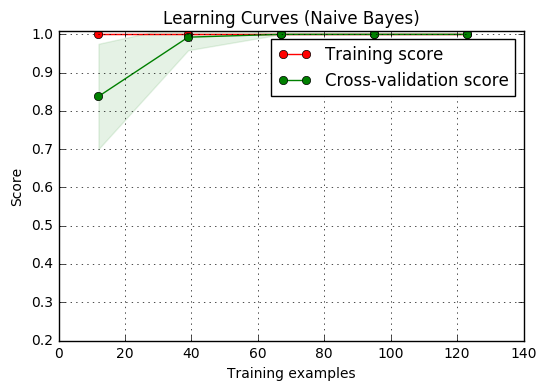

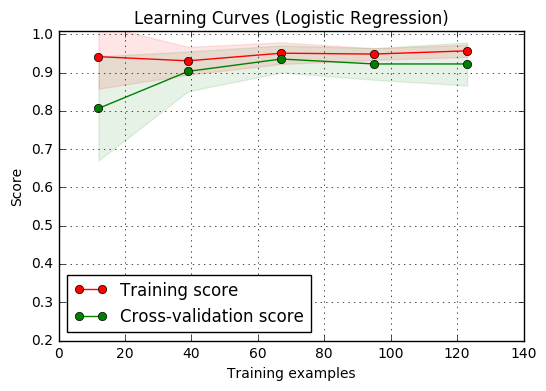

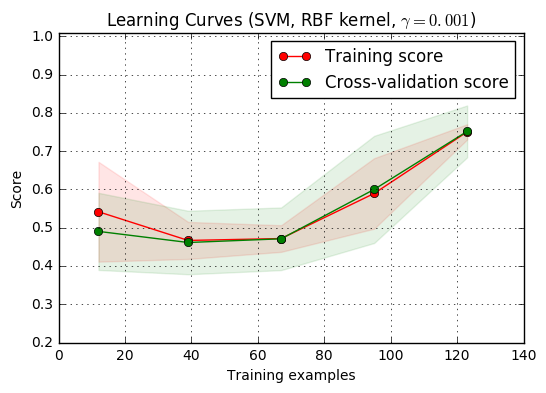

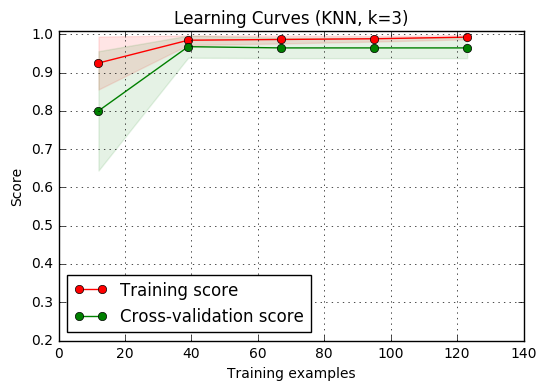

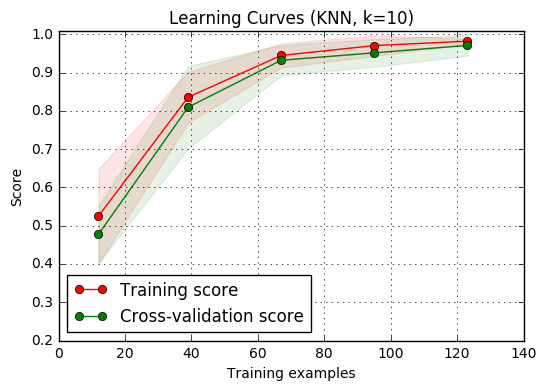

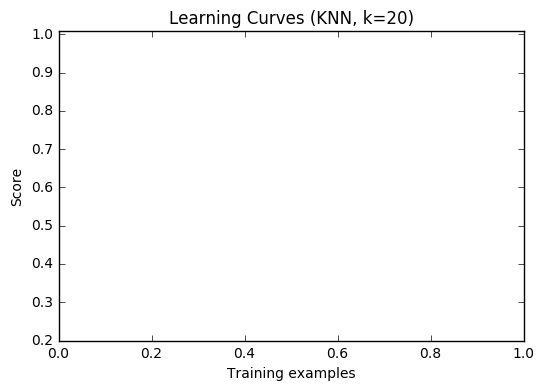

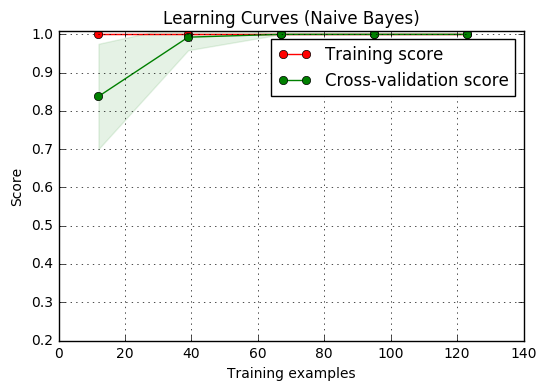

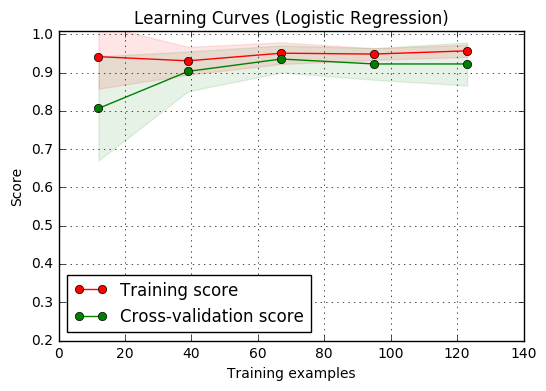

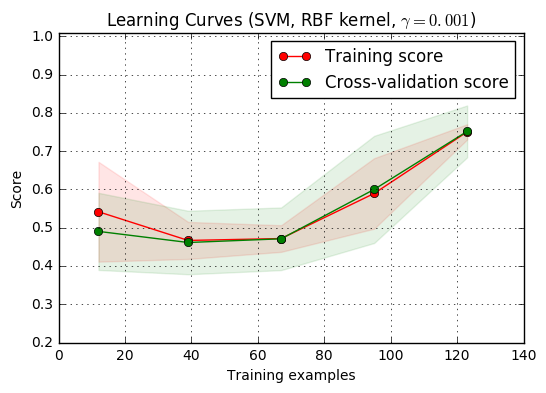

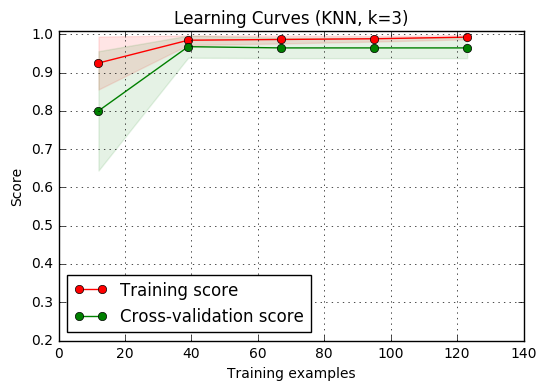

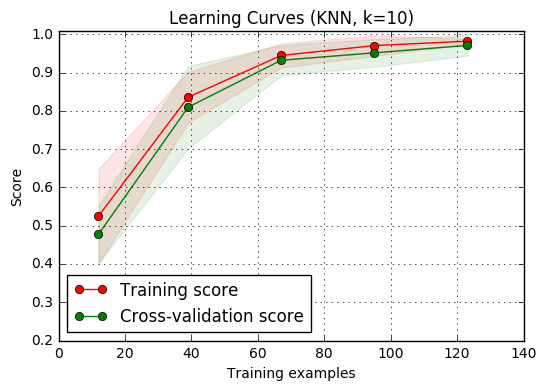

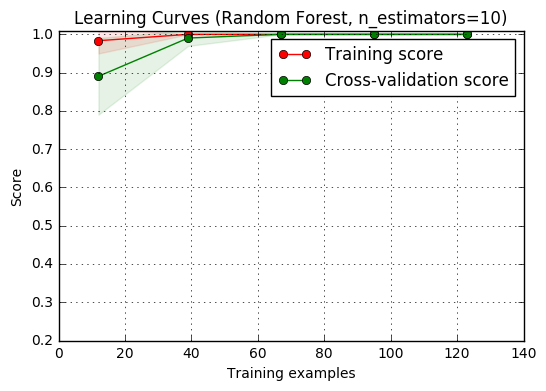

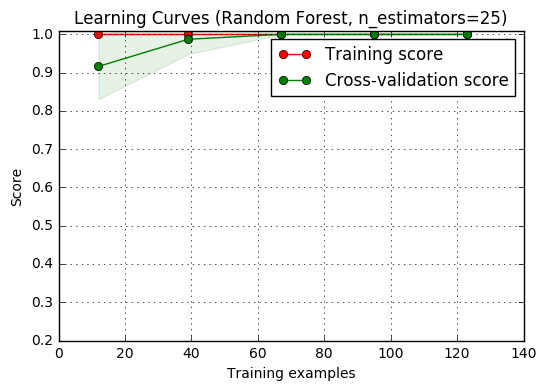

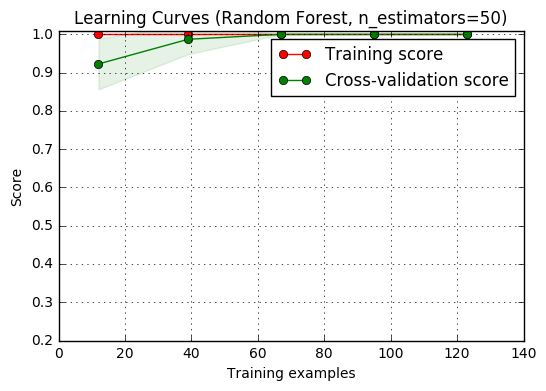

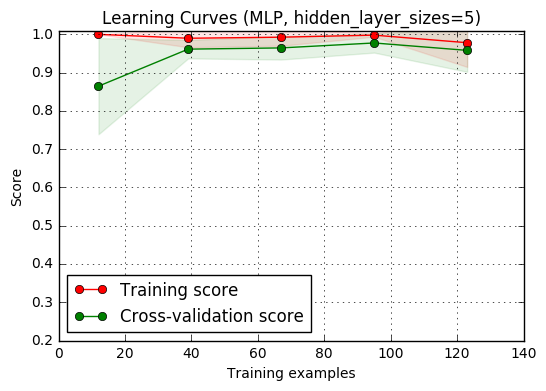

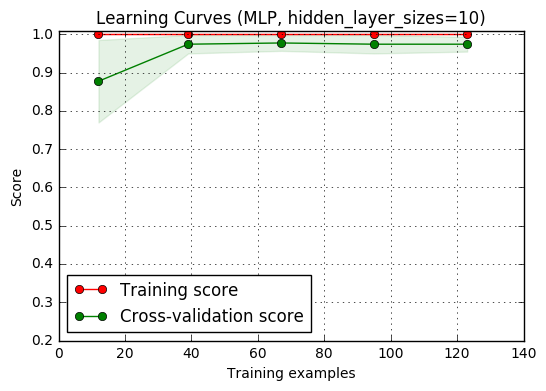

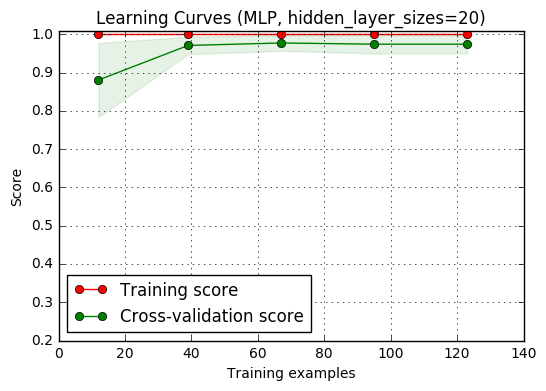

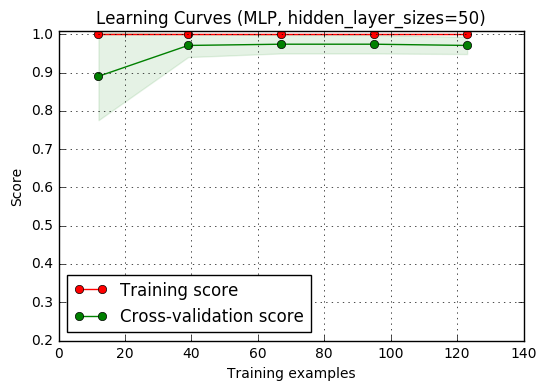

YAY!!


/Users/travissiems/anaconda/envs/mslc/lib/python3.5/site-packages/ipykernel/__main__.py:165: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


In [60]:
updater.update_model({"dsid":201})